# Pipeline de Dataset Supervisado ECG (NORMAL vs ANÓMALO)

Este notebook ejecuta el pipeline completo paso a paso:
1. Procesa datasets PTB-XL y MIMIC-IV-ECG
2. Etiqueta registros (NORMAL vs ANÓMALO)
3. Filtra señales de mala calidad
4. Aplica filtrado y normalización
5. Selecciona leads II, V1, V5
6. Resamplea a 10s y 500 Hz
7. Genera datasets balanceados
8. Genera train/val/test + 10 folds
9. Guarda todo en `/data/Datos_supervisados/`

**Ventaja**: Puedes ejecutar celda por celda y ver exactamente dónde se bloquea.


## 1. Configuración e Importaciones


In [1]:
import sys
import time
from pathlib import Path
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recargar módulo si es necesario (para incluir nuevas funciones)
import importlib
import supervised_ecg_pipeline
importlib.reload(supervised_ecg_pipeline)

# Importar módulos del pipeline
from supervised_ecg_pipeline import (
    OUTPUT_DIR,
    create_splits,
    create_splits_to_disk,
    create_stratified_folds,
    save_dataset,
    balance_dataset,
    ensure_dir,
    PTB_ROOT,
    MIMIC_ROOT,
)

# Intentar importar versión optimizada
try:
    from supervised_ecg_pipeline_fast import (
        process_mimic_dataset_fast,
        process_ptbxl_dataset_fast,
    )
    FAST_VERSION_AVAILABLE = True
    print("✓ Versión rápida (paralela) disponible")
except ImportError:
    from supervised_ecg_pipeline import (
        process_mimic_dataset,
        process_ptbxl_dataset,
    )
    FAST_VERSION_AVAILABLE = False
    print("⚠ Usando versión lenta (secuencial)")

print(f"✓ Directorio de salida: {OUTPUT_DIR}")

# ==================== CONFIGURACIÓN ====================
# Modifica estos valores según necesites
MAX_PTB = None  # None = todos, o poner número para pruebas (ej: 1000)
MAX_MIMIC = None  # None = todos, o poner número para pruebas (ej: 1000)
USE_FAST = FAST_VERSION_AVAILABLE
N_WORKERS = None  # None = auto (cpu_count - 1)
APPLY_QUALITY_CHECK = True
APPLY_NOTCH = True
NOTCH_FREQ = 50.0
NORMALIZE_METHOD = "minmax"
REJECT_UNVALIDATED = False
DO_BALANCE = True
MINIMAL_QUALITY = False  # True = deshabilitar checks menos críticos para más velocidad

if N_WORKERS is None and USE_FAST:
    import multiprocessing as mp
    N_WORKERS = max(1, mp.cpu_count() - 1)

print(f"\nConfiguración:")
print(f"  PTB-XL máximo: {MAX_PTB if MAX_PTB else 'Todos'}")
print(f"  MIMIC máximo: {MAX_MIMIC if MAX_MIMIC else 'Todos'}")
print(f"  Versión: {'RÁPIDA (paralela)' if USE_FAST else 'LENTA (secuencial)'}")
if USE_FAST:
    print(f"  Workers: {N_WORKERS}")
print(f"  Balancear: {DO_BALANCE}")
print(f"  Calidad mínima: {MINIMAL_QUALITY}")


KeyboardInterrupt: 

## 2. Procesar PTB-XL

**Ejecuta esta celda y espera a que termine. Si se bloquea, verás dónde.**


In [ ]:
# Inicializar variables
ptbxl_signals = None
ptbxl_labels = None
ptbxl_df = None

print("=" * 80)
print("PASO 1: Procesando PTB-XL")
print("=" * 80)

try:
    start_time = time.time()
    
    if USE_FAST:
        print(f"\n[PTB-XL] Iniciando procesamiento paralelo...")
        ptbxl_signals, ptbxl_labels, ptbxl_df = process_ptbxl_dataset_fast(
            overwrite=False,
            apply_quality_check=APPLY_QUALITY_CHECK and not MINIMAL_QUALITY,
            apply_notch=APPLY_NOTCH,
            notch_freq=NOTCH_FREQ,
            normalize_method=NORMALIZE_METHOD,
            reject_unvalidated=REJECT_UNVALIDATED,
            max_records=MAX_PTB,
            n_workers=N_WORKERS,
            verbose=True,
            prefilter_labels=False,
        )
    else:
        print(f"\n[PTB-XL] Iniciando procesamiento secuencial...")
        ptbxl_df_full = process_ptbxl_dataset(
            overwrite=False,
            apply_quality_check=APPLY_QUALITY_CHECK,
            apply_notch=APPLY_NOTCH,
            notch_freq=NOTCH_FREQ,
            normalize_method=NORMALIZE_METHOD,
            reject_unvalidated=REJECT_UNVALIDATED,
            max_records=MAX_PTB,
            verbose=True,
        )
        
        if len(ptbxl_df_full) > 0:
            print(f"  Extrayendo señales de DataFrame...")
            ptbxl_signals = np.stack(ptbxl_df_full["signal"].values, axis=0)
            ptbxl_labels = ptbxl_df_full["label"].values
            ptbxl_df = ptbxl_df_full.drop(columns=["signal"])
    
    elapsed = time.time() - start_time
    
    if ptbxl_signals is None or len(ptbxl_signals) == 0:
        print("\n⚠ No se procesaron registros de PTB-XL")
        ptbxl_signals = None
        ptbxl_labels = None
        ptbxl_df = None
    else:
        print(f"\n✓ PTB-XL COMPLETADO")
        print(f"  Tiempo: {elapsed/60:.2f} minutos")
        print(f"  Registros: {len(ptbxl_signals)}")
        print(f"  Normales: {(ptbxl_labels == 0).sum()}")
        print(f"  Anómalos: {(ptbxl_labels == 1).sum()}")
        print(f"  Shape: {ptbxl_signals.shape}")
        print(f"  Memoria: {ptbxl_signals.nbytes / 1024**3:.2f} GB")

except Exception as e:
    print(f"\n✗ ERROR procesando PTB-XL: {e}")
    import traceback
    traceback.print_exc()
    ptbxl_signals = None
    ptbxl_labels = None
    ptbxl_df = None


PASO 1: Procesando PTB-XL

[PTB-XL] Iniciando procesamiento paralelo...
[PTB-XL] Procesando 21799 registros directamente en paralelo (15 workers)...
  Iniciando procesamiento paralelo de 21799 registros...
  ✓ Completado: 979 válidos, 20820 rechazados

[PTB-XL] Completado:
  Procesados exitosamente: 979
  Rechazados: 20820
  Construyendo arrays finales de 979 registros...
  Extrayendo señales...
  ✓ Señales extraídas: shape (979, 5000, 3)
  Extrayendo labels...
  ✓ Labels extraídos: 979 labels
  Creando metadatos...
  ✓ Metadatos creados: 979 registros
  ✓ Arrays finales listos: signals=(979, 5000, 3), labels=(979,)

✓ PTB-XL COMPLETADO
  Tiempo: 0.43 minutos
  Registros: 979
  Normales: 397
  Anómalos: 582
  Shape: (979, 5000, 3)
  Memoria: 0.05 GB


## 3. Procesar MIMIC-IV-ECG

**Ejecuta esta celda y espera a que termine. Si se bloquea, verás dónde.**


In [ ]:
# Inicializar variables
mimic_signals = None
mimic_labels = None
mimic_df = None

print("=" * 80)
print("PASO 2: Procesando MIMIC-IV-ECG")
print("=" * 80)

try:
    start_time = time.time()
    
    if USE_FAST:
        print(f"\n[MIMIC] Iniciando procesamiento paralelo...")
        mimic_signals, mimic_labels, mimic_df = process_mimic_dataset_fast(
            overwrite=False,
            apply_quality_check=APPLY_QUALITY_CHECK and not MINIMAL_QUALITY,
            apply_notch=APPLY_NOTCH,
            notch_freq=NOTCH_FREQ,
            normalize_method=NORMALIZE_METHOD,
            max_records=MAX_MIMIC,
            n_workers=N_WORKERS,
            verbose=True,
            prefilter_labels=False,
        )
    else:
        print(f"\n[MIMIC] Iniciando procesamiento secuencial...")
        mimic_df_full = process_mimic_dataset(
            overwrite=False,
            report_column="report_1",
            apply_quality_check=APPLY_QUALITY_CHECK,
            apply_notch=APPLY_NOTCH,
            notch_freq=NOTCH_FREQ,
            normalize_method=NORMALIZE_METHOD,
            max_records=MAX_MIMIC,
            verbose=True,
        )
        
        if len(mimic_df_full) > 0:
            print(f"  Extrayendo señales de DataFrame...")
            signals_list = mimic_df_full["signal"].values.tolist()
            print(f"  Haciendo stack de {len(signals_list)} señales (esto puede tardar)...")
            mimic_signals = np.stack(signals_list, axis=0)
            del signals_list
            mimic_labels = mimic_df_full["label"].values
            mimic_df = mimic_df_full.drop(columns=["signal"])
    
    elapsed = time.time() - start_time
    
    if mimic_signals is None or len(mimic_signals) == 0:
        print("\n⚠ No se procesaron registros de MIMIC")
        mimic_signals = None
        mimic_labels = None
        mimic_df = None
    else:
        print(f"\n✓ MIMIC COMPLETADO")
        print(f"  Tiempo: {elapsed/60:.2f} minutos")
        print(f"  Registros: {len(mimic_signals)}")
        print(f"  Normales: {(mimic_labels == 0).sum()}")
        print(f"  Anómalos: {(mimic_labels == 1).sum()}")
        print(f"  Shape: {mimic_signals.shape}")
        print(f"  Memoria: {mimic_signals.nbytes / 1024**3:.2f} GB")

except Exception as e:
    print(f"\n✗ ERROR procesando MIMIC: {e}")
    import traceback
    traceback.print_exc()
    mimic_signals = None
    mimic_labels = None
    mimic_df = None


PASO 2: Procesando MIMIC-IV-ECG

[MIMIC] Iniciando procesamiento paralelo...
[MIMIC] Leyendo registros y preparando procesamiento paralelo (15 workers)...
[MIMIC] Procesando 800035 registros directamente en paralelo...
  Iniciando procesamiento paralelo de 800035 registros...
  ✓ Completado: 495265 válidos, 304770 rechazados

[MIMIC] Completado:
  Procesados exitosamente: 495265
  Rechazados: 304770
  Construyendo arrays finales de 495265 registros...
  Extrayendo señales...
  ✓ Señales extraídas: shape (495265, 5000, 3)
  Extrayendo labels...
  ✓ Labels extraídos: 495265 labels
  Creando metadatos...
  ✓ Metadatos creados: 495265 registros
  ✓ Arrays finales listos: signals=(495265, 5000, 3), labels=(495265,)

✓ MIMIC COMPLETADO
  Tiempo: 54.07 minutos
  Registros: 495265
  Normales: 192938
  Anómalos: 302327
  Shape: (495265, 5000, 3)
  Memoria: 27.68 GB


## 4. Construir Dataset Combinado


In [ ]:
print("=" * 80)
print("PASO 3: Construyendo dataset combinado")
print("=" * 80)

if (ptbxl_signals is None or len(ptbxl_signals) == 0) and (mimic_signals is None or len(mimic_signals) == 0):
    print("\n✗ ERROR: No hay datos para procesar")
    print(f"  PTB-XL: {ptbxl_signals is not None and len(ptbxl_signals) > 0}")
    print(f"  MIMIC: {mimic_signals is not None and len(mimic_signals) > 0}")
    raise ValueError("No hay datos para procesar")

try:
    start_time = time.time()
    
    # Combinar señales y labels
    all_signals = []
    all_labels = []
    all_metadata = []
    
    if ptbxl_signals is not None and len(ptbxl_signals) > 0:
        print(f"\n  Agregando PTB-XL: {len(ptbxl_signals)} registros")
        all_signals.append(ptbxl_signals)
        all_labels.append(ptbxl_labels)
        if ptbxl_df is not None and len(ptbxl_df) > 0:
            all_metadata.append(ptbxl_df)
    
    if mimic_signals is not None and len(mimic_signals) > 0:
        print(f"  Agregando MIMIC: {len(mimic_signals)} registros")
        all_signals.append(mimic_signals)
        all_labels.append(mimic_labels)
        if mimic_df is not None and len(mimic_df) > 0:
            all_metadata.append(mimic_df)
    
    print(f"\n  Combinando señales (esto puede tardar si hay muchas)...")
    X = np.concatenate(all_signals, axis=0)
    print(f"  ✓ Señales combinadas: {X.shape}")
    
    print(f"  Combinando labels...")
    y = np.concatenate(all_labels, axis=0)
    print(f"  ✓ Labels combinados: {len(y)} labels")
    
    if all_metadata:
        print(f"  Combinando metadatos...")
        metadata = pd.concat(all_metadata, ignore_index=True)
        print(f"  ✓ Metadatos combinados: {len(metadata)} registros")
    else:
        metadata = pd.DataFrame()
    
    # Liberar memoria
    del all_signals, all_labels, all_metadata
    if ptbxl_signals is not None:
        del ptbxl_signals, ptbxl_labels
    if mimic_signals is not None:
        del mimic_signals, mimic_labels
    
    elapsed = time.time() - start_time
    
    print(f"\n✓ Dataset combinado")
    print(f"  Tiempo: {elapsed:.2f} segundos")
    print(f"  Total registros: {len(X)}")
    print(f"  Normales: {(y == 0).sum()}")
    print(f"  Anómalos: {(y == 1).sum()}")
    print(f"  Shape: {X.shape}")
    print(f"  Memoria: {X.nbytes / 1024**3:.2f} GB")

except Exception as e:
    print(f"\n✗ ERROR construyendo dataset: {e}")
    import traceback
    traceback.print_exc()
    raise


PASO 3: Construyendo dataset combinado

  Agregando PTB-XL: 979 registros
  Agregando MIMIC: 495265 registros

  Combinando señales (esto puede tardar si hay muchas)...
  ✓ Señales combinadas: (496244, 5000, 3)
  Combinando labels...
  ✓ Labels combinados: 496244 labels
  Combinando metadatos...
  ✓ Metadatos combinados: 496244 registros

✓ Dataset combinado
  Tiempo: 712.72 segundos
  Total registros: 496244
  Normales: 193335
  Anómalos: 302909
  Shape: (496244, 5000, 3)
  Memoria: 27.73 GB


## 5. Balancear Dataset


In [ ]:
if DO_BALANCE:
    print("=" * 80)
    print("PASO 4: Balanceando dataset")
    print("=" * 80)
    
    try:
        start_time = time.time()
        
        print(f"\n  Balanceando dataset...")
        print(f"  Antes: {len(X)} registros")
        print(f"    Normales: {(y == 0).sum()}")
        print(f"    Anómalos: {(y == 1).sum()}")
        
        X_balanced, y_balanced, balanced_indices = balance_dataset(X, y, return_indices=True)
        
        # Mapear metadatos
        metadata = metadata.iloc[balanced_indices].copy()
        metadata.reset_index(drop=True, inplace=True)
        
        X = X_balanced
        y = y_balanced
        
        del X_balanced, y_balanced, balanced_indices
        
        elapsed = time.time() - start_time
        
        print(f"\n✓ Dataset balanceado")
        print(f"  Tiempo: {elapsed:.2f} segundos")
        print(f"  Después: {len(X)} registros")
        print(f"    Normales: {(y == 0).sum()}")
        print(f"    Anómalos: {(y == 1).sum()}")
        
    except Exception as e:
        print(f"\n✗ ERROR balanceando dataset: {e}")
        import traceback
        traceback.print_exc()
        raise
else:
    print("\n⏭ Saltando balanceo (DO_BALANCE=False)")


PASO 4: Balanceando dataset

  Balanceando dataset...
  Antes: 496244 registros
    Normales: 193335
    Anómalos: 302909

✓ Dataset balanceado
  Tiempo: 1293.67 segundos
  Después: 386670 registros
    Normales: 193335
    Anómalos: 193335


## 6. Crear Splits Train/Val/Test


In [ ]:
print("=" * 80)
print("PASO 5: Creando splits train/val/test")
print("=" * 80)

try:
    start_time = time.time()
    
    print(f"\n  Creando splits estratificados (70/15/15)...")
    X_train, y_train, X_val, y_val, X_test, y_test = create_splits(
        X, y,
        train_ratio=0.70,
        val_ratio=0.15,
        test_ratio=0.15,
    )
    
    # Crear metadata para cada split
    train_indices = np.arange(len(y_train))
    val_indices = np.arange(len(y_train), len(y_train) + len(y_val))
    test_indices = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test))
    
    metadata_train = metadata.iloc[train_indices].copy()
    metadata_val = metadata.iloc[val_indices].copy()
    metadata_test = metadata.iloc[test_indices].copy()
    
    elapsed = time.time() - start_time
    
    print(f"\n✓ Splits creados (tiempo: {elapsed:.2f}s)")
    print(f"\n  Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"    Normales: {(y_train == 0).sum()}")
    print(f"    Anómalos: {(y_train == 1).sum()}")
    print(f"    Memoria: {X_train.nbytes / 1024**3:.2f} GB")
    
    print(f"\n  Val: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
    print(f"    Normales: {(y_val == 0).sum()}")
    print(f"    Anómalos: {(y_val == 1).sum()}")
    print(f"    Memoria: {X_val.nbytes / 1024**3:.2f} GB")
    
    print(f"\n  Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
    print(f"    Normales: {(y_test == 0).sum()}")
    print(f"    Anómalos: {(y_test == 1).sum()}")
    print(f"    Memoria: {X_test.nbytes / 1024**3:.2f} GB")

except Exception as e:
    print(f"\n✗ ERROR creando splits: {e}")
    import traceback
    traceback.print_exc()
    raise


PASO 5: Creando splits train/val/test

  Creando splits estratificados (70/15/15)...

✗ ERROR creando splits: Unable to allocate 3.24 GiB for an array with shape (58001, 5000, 3) and data type float32


Traceback (most recent call last):
  File "C:\Users\tomas\AppData\Local\Temp\ipykernel_32336\1155616389.py", line 9, in <module>
    X_train, y_train, X_val, y_val, X_test, y_test = create_splits(
                                                     ^^^^^^^^^^^^^^
  File "s:\Proyecto final\Books\supervised_ecg_pipeline.py", line 950, in create_splits
    # Crear test split primero (más pequeño, ~15%)
                                    ^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 2944, in train_test_split
    return list(
           ^^^^^
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 2946, in <genexpr>
    (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Pytho

MemoryError: Unable to allocate 3.24 GiB for an array with shape (58001, 5000, 3) and data type float32

In [ ]:
# Recargar módulo
import importlib
import supervised_ecg_pipeline
importlib.reload(supervised_ecg_pipeline)
from supervised_ecg_pipeline import create_splits_to_disk

# Ahora ejecutar create_splits_to_disk

In [ ]:
print("=" * 80)
print("PASO 5: Creando splits train/val/test")
print("=" * 80)

try:
    start_time = time.time()
    
    print(f"\n  Creando splits estratificados (70/15/15) y guardando en disco...")
    print(f"  NOTA: Usando guardado directo en disco para evitar problemas de memoria")
    
    # Importar la nueva función si no está importada
    from supervised_ecg_pipeline import create_splits_to_disk
    
    # Usar función que guarda directamente en disco
    result = create_splits_to_disk(
        X, y,
        output_dir=OUTPUT_DIR,
        train_ratio=0.70,
        val_ratio=0.15,
        test_ratio=0.15,
        chunk_size=10000,  # Procesar en chunks de 10k registros
        random_state=42,  # Usar el mismo random_state
    )
    
    X_train, y_train, X_val, y_val, X_test, y_test, train_idx, val_idx, test_idx = result
    
    # Crear metadata para cada split usando los índices retornados
    print(f"\n  Creando metadata para cada split...")
    metadata_train = metadata.iloc[train_idx].copy().reset_index(drop=True)
    metadata_val = metadata.iloc[val_idx].copy().reset_index(drop=True)
    metadata_test = metadata.iloc[test_idx].copy().reset_index(drop=True)
    
    # Limpiar índices
    del train_idx, val_idx, test_idx
    
    elapsed = time.time() - start_time
    
    n_train = len(y_train)
    n_val = len(y_val)
    n_test = len(y_test)
    
    print(f"\n✓ Splits creados y guardados (tiempo: {elapsed:.2f}s)")
    print(f"\n  Train: {n_train} ({n_train/len(X)*100:.1f}%)")
    print(f"    Normales: {(y_train == 0).sum()}")
    print(f"    Anómalos: {(y_train == 1).sum()}")
    print(f"    Guardado en: {OUTPUT_DIR / 'numpy' / 'X_train.npy'}")
    
    print(f"\n  Val: {n_val} ({n_val/len(X)*100:.1f}%)")
    print(f"    Normales: {(y_val == 0).sum()}")
    print(f"    Anómalos: {(y_val == 1).sum()}")
    print(f"    Guardado en: {OUTPUT_DIR / 'numpy' / 'X_val.npy'}")
    
    print(f"\n  Test: {n_test} ({n_test/len(X)*100:.1f}%)")
    print(f"    Normales: {(y_test == 0).sum()}")
    print(f"    Anómalos: {(y_test == 1).sum()}")
    print(f"    Guardado en: {OUTPUT_DIR / 'numpy' / 'X_test.npy'}")

except Exception as e:
    print(f"\n✗ ERROR creando splits: {e}")
    import traceback
    traceback.print_exc()
    raise

PASO 5: Creando splits train/val/test

  Creando splits estratificados (70/15/15) y guardando en disco...
  NOTA: Usando guardado directo en disco para evitar problemas de memoria
    Calculando índices de splits...
    Guardando test split (58001 registros)...
    Guardando val split (58001 registros)...
    Guardando train split (270668 registros) en chunks...
    Cargando arrays en memoria (solo para compatibilidad)...
    ✓ Splits guardados en S:\Proyecto final\data\Datos_supervisados\numpy
    ✓ Índices guardados en S:\Proyecto final\data\Datos_supervisados\numpy\split_indices.npz

  Creando metadata para cada split...

✓ Splits creados y guardados (tiempo: 773.80s)

  Train: 270668 (70.0%)
    Normales: 135334
    Anómalos: 135334
    Guardado en: S:\Proyecto final\data\Datos_supervisados\numpy\X_train.npy

  Val: 58001 (15.0%)
    Normales: 29000
    Anómalos: 29001
    Guardado en: S:\Proyecto final\data\Datos_supervisados\numpy\X_val.npy

  Test: 58001 (15.0%)
    Normales: 29

## 7. Crear Folds Estratificados


In [ ]:
print("=" * 80)
print("PASO 6: Creando folds estratificados (10 folds)")
print("=" * 80)

try:
    start_time = time.time()
    
    print(f"\n  Creando 10 folds estratificados...")
    folds = create_stratified_folds(X_train, y_train, n_splits=10)
    folds_train = [fold[0] for fold in folds]
    folds_val = [fold[1] for fold in folds]
    
    elapsed = time.time() - start_time
    
    print(f"\n✓ {len(folds)} folds creados (tiempo: {elapsed:.2f}s)")
    for i, (train_idx, val_idx) in enumerate(folds[:3]):  # Mostrar solo primeros 3
        print(f"  Fold {i+1}: Train={len(train_idx)}, Val={len(val_idx)}")
    print(f"  ... (mostrando solo primeros 3 folds)")

except Exception as e:
    print(f"\n✗ ERROR creando folds: {e}")
    import traceback
    traceback.print_exc()
    raise


PASO 6: Creando folds estratificados (10 folds)

  Creando 10 folds estratificados...

✓ 10 folds creados (tiempo: 0.21s)
  Fold 1: Train=243601, Val=27067
  Fold 2: Train=243601, Val=27067
  Fold 3: Train=243601, Val=27067
  ... (mostrando solo primeros 3 folds)


## 8. Guardar Dataset


In [ ]:
# Recargar módulo
import importlib
import supervised_ecg_pipeline
importlib.reload(supervised_ecg_pipeline)
from supervised_ecg_pipeline import save_dataset
print("=" * 80)
print("PASO 7: Guardando dataset")
print("=" * 80)

try:
    start_time = time.time()
    
    print(f"\n  Preparando guardado...")
    print(f"  X_train: {X_train.shape} ({X_train.nbytes / 1024**3:.2f} GB)")
    print(f"  X_val: {X_val.shape} ({X_val.nbytes / 1024**3:.2f} GB)")
    print(f"  X_test: {X_test.shape} ({X_test.nbytes / 1024**3:.2f} GB)")
    
    save_dataset(
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        metadata_train, metadata_val, metadata_test,
        folds_train, folds_val,
        output_dir=OUTPUT_DIR,
    )
    
    elapsed = time.time() - start_time
    
    print(f"\n✓ Dataset guardado exitosamente")
    print(f"  Tiempo: {elapsed/60:.2f} minutos")
    print(f"  Ubicación: {OUTPUT_DIR}")

except Exception as e:
    print(f"\n✗ ERROR guardando dataset: {e}")
    import traceback
    traceback.print_exc()
    raise


PASO 7: Guardando dataset

  Preparando guardado...
  X_train: (270668, 5000, 3) (15.12 GB)
  X_val: (58001, 5000, 3) (3.24 GB)
  X_test: (58001, 5000, 3) (3.24 GB)

Iniciando guardado de dataset...
  Guardando arrays numpy...
    ⏭ X_train.npy ya existe en disco, omitiendo guardado
    ⏭ y_train.npy ya existe en disco, omitiendo guardado
    ⏭ X_val.npy ya existe en disco, omitiendo guardado
    ⏭ y_val.npy ya existe en disco, omitiendo guardado
    ⏭ X_test.npy ya existe en disco, omitiendo guardado
    ⏭ y_test.npy ya existe en disco, omitiendo guardado
  Guardando metadatos...
    Guardando master_labels.csv...
    ✓ master_labels.csv guardado
    Guardando master_labels_full.csv...
    ✓ master_labels_full.csv guardado
  Guardando folds...
    Guardando folds_train_indices.npy...
    ✓ folds_train_indices.npy guardado
    Guardando folds_val_indices.npy...
    ✓ folds_val_indices.npy guardado

✓ Dataset guardado exitosamente en S:\Proyecto final\data\Datos_supervisados
  Train: 27

## 9. Verificar Datos Guardados (Opcional)


In [ ]:
# Verificar que los archivos se guardaron correctamente
print("\n" + "=" * 80)
print("VERIFICACIÓN: Archivos guardados")
print("=" * 80)

import os

files_to_check = [
    "numpy/X_train.npy",
    "numpy/y_train.npy",
    "numpy/X_val.npy",
    "numpy/y_val.npy",
    "numpy/X_test.npy",
    "numpy/y_test.npy",
    "metadata/master_labels.csv",
    "metadata/master_labels_full.csv",
    "metadata/folds_train_indices.npy",
    "metadata/folds_val_indices.npy",
]

all_ok = True
for file_path in files_to_check:
    full_path = OUTPUT_DIR / file_path
    if full_path.exists():
        size_mb = full_path.stat().st_size / 1024**2
        print(f"  ✓ {file_path} ({size_mb:.2f} MB)")
    else:
        print(f"  ✗ {file_path} - NO ENCONTRADO")
        all_ok = False

if all_ok:
    print("\n✓ Todos los archivos se guardaron correctamente")
else:
    print("\n⚠ Algunos archivos no se encontraron")



VERIFICACIÓN: Archivos guardados
  ✓ numpy/X_train.npy (15487.75 MB)
  ✓ numpy/y_train.npy (2.07 MB)
  ✓ numpy/X_val.npy (3318.84 MB)
  ✓ numpy/y_val.npy (0.44 MB)
  ✓ numpy/X_test.npy (3318.84 MB)
  ✓ numpy/y_test.npy (0.44 MB)
  ✓ metadata/master_labels.csv (23.29 MB)
  ✓ metadata/master_labels_full.csv (35.31 MB)
  ✓ metadata/folds_train_indices.npy (18.59 MB)
  ✓ metadata/folds_val_indices.npy (2.07 MB)

✓ Todos los archivos se guardaron correctamente


## 10. Visualizar Ejemplos (Opcional)


In [ ]:
# Visualizar algunos ejemplos
from supervised_ecg_pipeline import plot_ecg_comparison

n_examples = 3  # Número de ejemplos a visualizar

print(f"\nGenerando {n_examples} ejemplos visuales...")

ensure_dir(OUTPUT_DIR / "raw_examples")

indices = np.random.choice(len(X_test), size=min(n_examples, len(X_test)), replace=False)

for i, idx in enumerate(indices):
    signal = X_test[idx]
    label = y_test[idx]
    record_id = metadata_test.iloc[idx]["record_id"]
    
    title = f"{record_id} - {'NORMAL' if label == 0 else 'ANÓMALO'}"
    save_path = OUTPUT_DIR / "raw_examples" / f"example_{i+1:03d}_{str(record_id).replace('/', '_')}.png"
    
    print(f"  Generando ejemplo {i+1}/{n_examples}: {record_id}...")
    plot_ecg_comparison(
        raw=signal,
        filtered=None,
        normalized=signal,
        title=title,
        save_path=save_path,
    )

print(f"\n✓ {n_examples} ejemplos visuales creados en {OUTPUT_DIR / 'raw_examples'}")



Generando 3 ejemplos visuales...
  Generando ejemplo 1/3: mimic_13744125_41662601...
  Generando ejemplo 2/3: mimic_18832132_48870396...
  Generando ejemplo 3/3: mimic_12182445_49330246...

✓ 3 ejemplos visuales creados en S:\Proyecto final\data\Datos_supervisados\raw_examples


## Resumen Final


VISUALIZACIÓN DE ECG DESDE DISCO

🔍 Visualizando ejemplos del TEST set...
📊 Visualizando 6 ejemplos de ECG desde split 'test'
   Cargando desde: S:\Proyecto final\data\Datos_supervisados\numpy
   Cargando señales...
   Cargando metadata...

   Generando visualizaciones...

✓ Visualización guardada en: S:\Proyecto final\data\Datos_supervisados\visualizations\test\ecg_examples_test_6.png


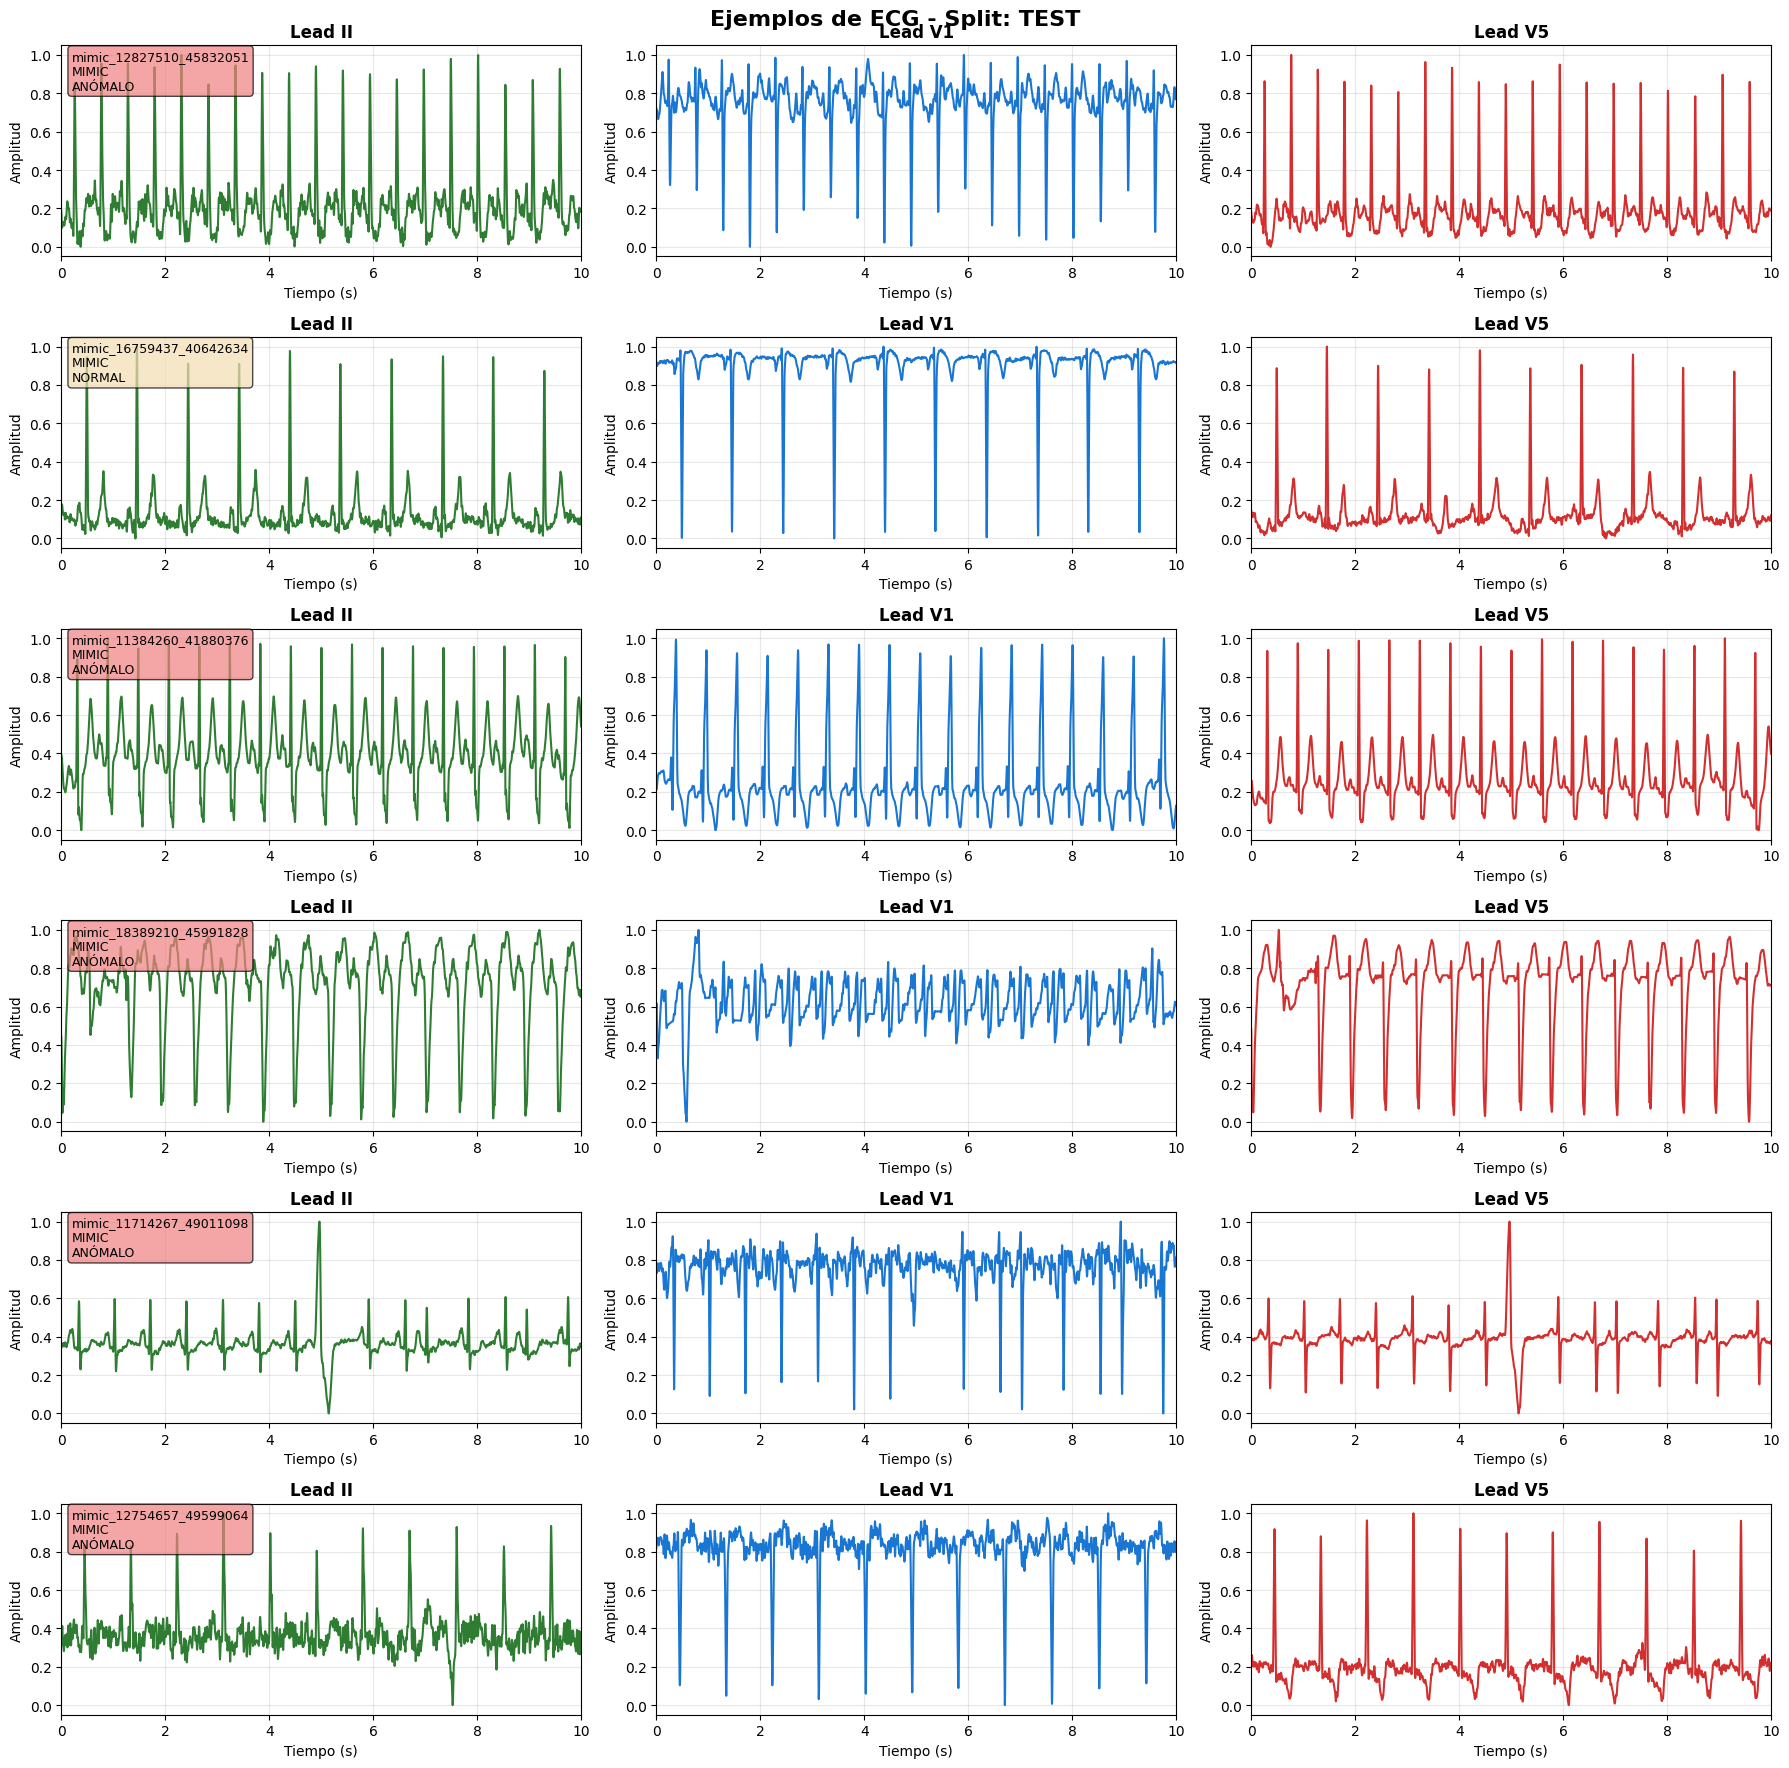


📊 Estadísticas de los ejemplos mostrados:
   Normales: 1/6
   Anómalos: 5/6


In [ ]:
# ==================== VISUALIZACIÓN DE ECG (DESDE DISCO) ====================
# Esta celda muestra ejemplos visuales de ECG desde los archivos guardados en disco

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from supervised_ecg_pipeline import OUTPUT_DIR, plot_ecg_comparison, ensure_dir

def visualize_ecg_examples(n_examples=6, split='test', random_seed=42):
    """
    Visualizar ejemplos de ECG desde los archivos guardados en disco
    
    Args:
        n_examples: Número de ejemplos a visualizar
        split: 'train', 'val' o 'test'
        random_seed: Semilla para selección aleatoria
    """
    numpy_dir = OUTPUT_DIR / "numpy"
    metadata_dir = OUTPUT_DIR / "metadata"
    
    # Archivos a leer
    X_file = numpy_dir / f"X_{split}.npy"
    y_file = numpy_dir / f"y_{split}.npy"
    labels_file = metadata_dir / "master_labels_full.csv"
    
    if not X_file.exists() or not y_file.exists():
        print(f"⚠ Archivos no encontrados para split '{split}'")
        print(f"   Buscando: {X_file}")
        print(f"   Buscando: {y_file}")
        return
    
    print(f"📊 Visualizando {n_examples} ejemplos de ECG desde split '{split}'")
    print(f"   Cargando desde: {numpy_dir}")
    
    # Cargar datos (usar mmap para no cargar todo en memoria)
    print(f"   Cargando señales...")
    X_data = np.load(X_file, mmap_mode='r')
    y_labels = np.load(y_file)
    
    print(f"   Cargando metadata...")
    metadata_df = pd.read_csv(labels_file) if labels_file.exists() else None
    
    # Obtener índices aleatorios
    np.random.seed(random_seed)
    n_samples = len(y_labels)
    indices = np.random.choice(n_samples, size=min(n_examples, n_samples), replace=False)
    
    # Crear directorio de salida para imágenes
    output_dir = OUTPUT_DIR / "visualizations" / split
    ensure_dir(output_dir)
    
    print(f"\n   Generando visualizaciones...")
    
    # Crear figura con subplots
    fig, axes = plt.subplots(n_examples, 3, figsize=(18, 3 * n_examples))
    if n_examples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Ejemplos de ECG - Split: {split.upper()}', fontsize=16, fontweight='bold')
    
    lead_names = ['II', 'V1', 'V5']
    colors = ['#2E7D32', '#1976D2', '#D32F2F']
    
    for idx, i in enumerate(indices):
        # Cargar señal específica
        signal = X_data[i]
        label = int(y_labels[i])
        
        # Obtener información del registro si está disponible
        if metadata_df is not None and i < len(metadata_df):
            record_id = metadata_df.iloc[i].get('record_id', f'idx_{i}')
            source = metadata_df.iloc[i].get('source', 'Unknown')
        else:
            record_id = f'idx_{i}'
            source = 'Unknown'
        
        label_text = 'NORMAL' if label == 0 else 'ANÓMALO'
        
        # Plotear los 3 leads
        for lead_idx in range(3):
            ax = axes[idx, lead_idx]
            
            # Crear tiempo en segundos (10 segundos, 500 Hz)
            time_sec = np.arange(len(signal)) / 500.0
            
            # Plotear señal
            ax.plot(time_sec, signal[:, lead_idx], color=colors[lead_idx], linewidth=1.5)
            ax.set_xlabel('Tiempo (s)', fontsize=10)
            ax.set_ylabel('Amplitud', fontsize=10)
            ax.set_title(f'Lead {lead_names[lead_idx]}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 10)
            
            # Agregar información solo en la primera columna
            if lead_idx == 0:
                ax.text(0.02, 0.98, f'{record_id}\n{source}\n{label_text}', 
                       transform=ax.transAxes, fontsize=9,
                       verticalalignment='top', bbox=dict(boxstyle='round', 
                       facecolor='wheat' if label == 0 else 'lightcoral', alpha=0.7))
    
    plt.tight_layout()
    
    # Guardar figura
    save_path = output_dir / f'ecg_examples_{split}_{n_examples}.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Visualización guardada en: {save_path}")
    
    # Mostrar figura
    plt.show()
    
    # Mostrar estadísticas
    print(f"\n📊 Estadísticas de los ejemplos mostrados:")
    normal_count = (y_labels[indices] == 0).sum()
    anomalo_count = (y_labels[indices] == 1).sum()
    print(f"   Normales: {normal_count}/{n_examples}")
    print(f"   Anómalos: {anomalo_count}/{n_examples}")

# Visualizar ejemplos de cada split
print("=" * 80)
print("VISUALIZACIÓN DE ECG DESDE DISCO")
print("=" * 80)

# Visualizar ejemplos del test set (más representativo)
print("\n🔍 Visualizando ejemplos del TEST set...")
visualize_ecg_examples(n_examples=6, split='test', random_seed=42)


In [ ]:
# ==================== VISUALIZACIÓN DEL PROCESO COMPLETO: CRUDO → FILTRADO → NORMALIZADO ====================
# Esta celda muestra el proceso completo de procesamiento de ECG desde los archivos originales

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import wfdb
from scipy.signal import butter, filtfilt, iirnotch, resample

from supervised_ecg_pipeline import (
    OUTPUT_DIR, PTB_ROOT, MIMIC_ROOT, TARGET_LEADS, SAMPLING_RATE,
    plot_ecg_comparison, ensure_dir, map_lead_names, get_sig_names,
    filter_signal, resample_signal, normalize_signal_minmax
)

def process_signal_show_steps(signal_raw, original_fs, apply_notch=True, notch_freq=50.0):
    """
    Procesar señal paso a paso para mostrar cada etapa (CRUDO → FILTRADO → NORMALIZADO)
    
    Returns:
        raw: Señal cruda (después de extraer leads)
        filtered: Señal filtrada (notch + bandpass)
        normalized: Señal normalizada (minmax)
    """
    fs = SAMPLING_RATE  # 500 Hz objetivo
    
    # 1. RAW: Señal original (ya tiene los 3 leads II, V1, V5)
    raw = signal_raw.copy()
    
    # 2. FILTERED: Aplicar filtros
    # Resamplear primero si es necesario
    if original_fs != fs:
        n_samples_target = int(len(raw) * fs / original_fs)
        filtered = resample(raw, n_samples_target, axis=0).astype(np.float32)
    else:
        filtered = raw.copy()
    
    # Aplicar notch filter
    if apply_notch:
        b, a = iirnotch(notch_freq, 30, fs)
        filtered = filtfilt(b, a, filtered, axis=0)
    
    # Aplicar bandpass filter (0.5 - 40 Hz)
    nyq = fs / 2
    low = 0.5 / nyq
    high = 40 / nyq
    b, a = butter(4, [low, high], btype='band')
    filtered = filtfilt(b, a, filtered, axis=0)
    
    # Asegurar longitud correcta (5000 muestras)
    target_len = SAMPLING_RATE * 10  # 5000
    if len(filtered) > target_len:
        filtered = filtered[:target_len]
    elif len(filtered) < target_len:
        pad_len = target_len - len(filtered)
        filtered = np.vstack([filtered, np.tile(filtered[-1:], (pad_len, 1))])
    
    # 3. NORMALIZED: Normalizar con minmax
    normalized = filtered.copy()
    normalized, _, _ = normalize_signal_minmax(normalized)
    
    return raw, filtered, normalized

def visualize_ecg_processing_complete(n_examples=3, split='test', random_seed=42):
    """
    Visualizar el proceso completo: CRUDO → FILTRADO → NORMALIZADO
    Carga señales originales desde archivos fuente y muestra las 3 etapas
    """
    numpy_dir = OUTPUT_DIR / "numpy"
    metadata_dir = OUTPUT_DIR / "metadata"
    
    y_file = numpy_dir / f"y_{split}.npy"
    labels_file = metadata_dir / "master_labels_full.csv"
    
    if not y_file.exists():
        print(f"⚠ Archivos no encontrados para split '{split}'")
        return
    
    print(f"📊 Visualizando proceso completo de {n_examples} ejemplos desde split '{split}'")
    print(f"   Mostrando: CRUDO → FILTRADO → NORMALIZADO")
    
    # Cargar labels y metadata
    y_labels = np.load(y_file)
    metadata_df = pd.read_csv(labels_file) if labels_file.exists() else None
    
    if metadata_df is None:
        print("⚠ No se encontró metadata. No se pueden cargar señales originales.")
        return
    
    # Obtener índices aleatorios
    np.random.seed(random_seed)
    n_samples = len(y_labels)
    indices = np.random.choice(n_samples, size=min(n_examples, n_samples), replace=False)
    
    # Crear directorio de salida
    output_dir = OUTPUT_DIR / "visualizations" / "processing_complete" / split
    ensure_dir(output_dir)
    
    print(f"\n   Cargando y procesando señales originales...")
    
    for idx, i in enumerate(indices):
        row = metadata_df.iloc[i]
        record_id = row.get('record_id', f'idx_{i}')
        source = row.get('source', 'Unknown')
        label = int(y_labels[i])
        label_text = 'NORMAL' if label == 0 else 'ANÓMALO'
        
        try:
            print(f"   [{idx+1}/{n_examples}] Procesando {record_id} ({source})...")
            
            # Cargar señal original
            if source == 'PTB-XL':
                original_id = row.get('original_id', None)
                if original_id is None:
                    continue
                db_csv = PTB_ROOT / "ptbxl_database.csv"
                ptb_df = pd.read_csv(db_csv, index_col="ecg_id")
                if original_id not in ptb_df.index:
                    continue
                filename_hr = ptb_df.loc[original_id, 'filename_hr']
                record_path = PTB_ROOT / filename_hr
                signal_full, meta = wfdb.rdsamp(str(record_path))
                original_fs = 500
                
            elif source == 'MIMIC':
                subject_id = row.get('subject_id', None)
                study_id = row.get('study_id', None)
                if subject_id is None or study_id is None:
                    continue
                record_list = MIMIC_ROOT / "record_list.csv"
                if not record_list.exists():
                    continue
                rec_df = pd.read_csv(record_list)
                path_row = rec_df[(rec_df['subject_id'] == subject_id) & (rec_df['study_id'] == study_id)]
                if len(path_row) == 0:
                    continue
                record_path_str = path_row.iloc[0]['path']
                record_path = MIMIC_ROOT / record_path_str
                signal_full, meta = wfdb.rdsamp(str(record_path))
                original_fs = meta.get('fs', 250) if isinstance(meta, dict) else getattr(meta, 'fs', 250)
            else:
                continue
            
            # Extraer solo los leads II, V1, V5
            sig_names = get_sig_names(meta)
            lead_mapping = map_lead_names(sig_names, TARGET_LEADS)
            indices_leads = [lead_mapping[lead] for lead in TARGET_LEADS]
            signal_raw = signal_full[:, indices_leads].astype(np.float32)
            
            # Procesar señal paso a paso
            signal_raw_proc, signal_filtered, signal_normalized = process_signal_show_steps(
                signal_raw, original_fs, apply_notch=True, notch_freq=50.0
            )
            
            # Crear título
            title = f"{record_id} - {source} - {label_text}"
            
            # Visualizar usando plot_ecg_comparison
            save_path = output_dir / f"process_{idx+1:02d}_{str(record_id).replace('/', '_').replace(':', '_')}.png"
            plot_ecg_comparison(
                raw=signal_raw_proc,
                filtered=signal_filtered,
                normalized=signal_normalized,
                fs=SAMPLING_RATE,
                title=title,
                save_path=save_path,
                figsize=(15, 10)
            )
            
            print(f"     ✓ Guardado: {save_path.name}")
            
        except Exception as e:
            print(f"     ✗ Error procesando {record_id}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n✓ Visualizaciones guardadas en: {output_dir}")
    print(f"   Total: {n_examples} ejemplos mostrando CRUDO → FILTRADO → NORMALIZADO")

# Visualizar proceso completo
print("=" * 80)
print("VISUALIZACIÓN DEL PROCESO COMPLETO DE ECG")
print("=" * 80)
print("Mostrando: CRUDO → FILTRADO → NORMALIZADO")
print("\n🔍 Visualizando ejemplos del TEST set...")
visualize_ecg_processing_complete(n_examples=3, split='test', random_seed=42)


VISUALIZACIÓN DEL PROCESO COMPLETO DE ECG
Mostrando: CRUDO → FILTRADO → NORMALIZADO

🔍 Visualizando ejemplos del TEST set...
📊 Visualizando proceso completo de 3 ejemplos desde split 'test'
   Mostrando: CRUDO → FILTRADO → NORMALIZADO

   Cargando y procesando señales originales...
   [1/3] Procesando mimic_12827510_45832051 (MIMIC)...
     ✓ Guardado: process_01_mimic_12827510_45832051.png
   [2/3] Procesando mimic_16759437_40642634 (MIMIC)...
     ✓ Guardado: process_02_mimic_16759437_40642634.png
   [3/3] Procesando mimic_11384260_41880376 (MIMIC)...
     ✓ Guardado: process_03_mimic_11384260_41880376.png

✓ Visualizaciones guardadas en: S:\Proyecto final\data\Datos_supervisados\visualizations\processing_complete\test
   Total: 3 ejemplos mostrando CRUDO → FILTRADO → NORMALIZADO


In [ ]:
# ==================== RESUMEN VISUAL DE LAS 3 ETAPAS (DESDE DISCO) ====================
# Esta celda muestra el estado de las 3 etapas basándose en los archivos guardados en disco

from IPython.display import HTML, display
from pathlib import Path
import numpy as np
import pandas as pd

def show_stages_status_from_disk():
    """Mostrar resumen visual del estado de las 3 etapas leyendo desde disco"""
    
    # Importar OUTPUT_DIR del módulo
    from supervised_ecg_pipeline import OUTPUT_DIR
    
    numpy_dir = OUTPUT_DIR / "numpy"
    metadata_dir = OUTPUT_DIR / "metadata"
    
    # ETAPA 3: Verificar dataset combinado (train + val + test)
    stage3_complete = False
    stage3_count = 0
    stage3_normales = 0
    stage3_anomalos = 0
    
    try:
        # Verificar si existen los archivos del dataset final
        train_file = numpy_dir / "X_train.npy"
        val_file = numpy_dir / "X_val.npy"
        test_file = numpy_dir / "X_test.npy"
        y_train_file = numpy_dir / "y_train.npy"
        y_val_file = numpy_dir / "y_val.npy"
        y_test_file = numpy_dir / "y_test.npy"
        
        if train_file.exists() and val_file.exists() and test_file.exists():
            stage3_complete = True
            
            # Leer solo los shapes para no cargar todo en memoria
            train_data = np.load(train_file, mmap_mode='r')
            val_data = np.load(val_file, mmap_mode='r')
            test_data = np.load(test_file, mmap_mode='r')
            
            n_train = train_data.shape[0]
            n_val = val_data.shape[0]
            n_test = test_data.shape[0]
            
            stage3_count = n_train + n_val + n_test
            
            # Leer labels para contar normales y anómalos
            if y_train_file.exists() and y_val_file.exists() and y_test_file.exists():
                y_train = np.load(y_train_file)
                y_val = np.load(y_val_file)
                y_test = np.load(y_test_file)
                
                stage3_normales = int((y_train == 0).sum() + (y_val == 0).sum() + (y_test == 0).sum())
                stage3_anomalos = int((y_train == 1).sum() + (y_val == 1).sum() + (y_test == 1).sum())
    except Exception as e:
        print(f"Error leyendo etapa 3: {e}")
    
    # ETAPA 1 y 2: Verificar desde metadata si es posible
    # Intentar leer desde master_labels para contar por fuente
    stage1_complete = False
    stage1_count = 0
    stage1_normales = 0
    stage1_anomalos = 0
    
    stage2_complete = False
    stage2_count = 0
    stage2_normales = 0
    stage2_anomalos = 0
    
    try:
        labels_file = metadata_dir / "master_labels.csv"
        if labels_file.exists():
            df = pd.read_csv(labels_file)
            
            # Contar por fuente (source column)
            if 'source' in df.columns:
                # ETAPA 1: PTB-XL
                ptbxl_data = df[df['source'] == 'PTB-XL']
                if len(ptbxl_data) > 0:
                    stage1_complete = True
                    stage1_count = len(ptbxl_data)
                    stage1_normales = int((ptbxl_data['label'] == 0).sum())
                    stage1_anomalos = int((ptbxl_data['label'] == 1).sum())
                
                # ETAPA 2: MIMIC
                mimic_data = df[df['source'] == 'MIMIC']
                if len(mimic_data) > 0:
                    stage2_complete = True
                    stage2_count = len(mimic_data)
                    stage2_normales = int((mimic_data['label'] == 0).sum())
                    stage2_anomalos = int((mimic_data['label'] == 1).sum())
    except Exception as e:
        print(f"Error leyendo metadata para etapas 1 y 2: {e}")
    
    # Si no se encontró en metadata, intentar verificar si existen archivos intermedios
    # (Esto es opcional, dependiendo de si guardaste archivos intermedios)
    
    # Mostrar información de ubicación
    print(f"\n📁 Leyendo desde: {OUTPUT_DIR}")
    print(f"   numpy/: {numpy_dir}")
    print(f"   metadata/: {metadata_dir}")
    
    # Crear HTML visual
    html = f"""
    <div style="font-family: Arial, sans-serif; padding: 25px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 15px; color: white; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <h2 style="margin-top: 0; text-align: center; font-size: 28px;">📊 RESUMEN DE LAS 3 ETAPAS (DESDE DISCO)</h2>
        <p style="text-align: center; margin: 10px 0; font-size: 14px; opacity: 0.9;">Leyendo desde: {OUTPUT_DIR}</p>
        <table style="width: 100%; border-collapse: collapse; margin-top: 20px; background-color: rgba(255,255,255,0.1); border-radius: 10px; overflow: hidden;">
            <tr style="background-color: rgba(255,255,255,0.3);">
                <th style="padding: 15px; text-align: left; border-bottom: 2px solid white; font-size: 16px;">Etapa</th>
                <th style="padding: 15px; text-align: center; border-bottom: 2px solid white; font-size: 16px;">Estado</th>
                <th style="padding: 15px; text-align: right; border-bottom: 2px solid white; font-size: 16px;">Total</th>
                <th style="padding: 15px; text-align: right; border-bottom: 2px solid white; font-size: 16px;">Normales</th>
                <th style="padding: 15px; text-align: right; border-bottom: 2px solid white; font-size: 16px;">Anómalos</th>
            </tr>
            <tr style="background-color: rgba(255,255,255,0.05);">
                <td style="padding: 15px; font-size: 15px;">📁 ETAPA 1: PTB-XL</td>
                <td style="padding: 15px; text-align: center; font-weight: bold; font-size: 15px;">{'✅ COMPLETADA' if stage1_complete else '⏳ Pendiente'}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage1_count:,}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage1_normales:,}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage1_anomalos:,}</td>
            </tr>
            <tr style="background-color: rgba(255,255,255,0.1);">
                <td style="padding: 15px; font-size: 15px;">🏥 ETAPA 2: MIMIC-IV</td>
                <td style="padding: 15px; text-align: center; font-weight: bold; font-size: 15px;">{'✅ COMPLETADA' if stage2_complete else '⏳ Pendiente'}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage2_count:,}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage2_normales:,}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage2_anomalos:,}</td>
            </tr>
            <tr style="background-color: rgba(255,255,255,0.05);">
                <td style="padding: 15px; font-size: 15px;">🔄 ETAPA 3: Combinando</td>
                <td style="padding: 15px; text-align: center; font-weight: bold; font-size: 15px;">{'✅ COMPLETADA' if stage3_complete else '⏳ Pendiente'}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px; font-weight: bold;">{stage3_count:,}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage3_normales:,}</td>
                <td style="padding: 15px; text-align: right; font-size: 15px;">{stage3_anomalos:,}</td>
            </tr>
        </table>
        <div style="margin-top: 20px; padding: 15px; background-color: rgba(255,255,255,0.2); border-radius: 10px; text-align: center;">
            <p style="margin: 0; font-size: 18px; font-weight: bold;">
                {'🎉 ¡Todas las etapas completadas!' if (stage1_complete and stage2_complete and stage3_complete) else '⏳ Procesando...'}
            </p>
        </div>
    </div>
    """
    display(HTML(html))
    
    # También imprimir resumen en texto
    print("\n" + "=" * 100)
    print("RESUMEN DE LAS 3 ETAPAS (LEYENDO DESDE DISCO)")
    print("=" * 100)
    print(f"ETAPA 1: PTB-XL        {'✅ COMPLETADA' if stage1_complete else '⏳ Pendiente':20s} | Total: {stage1_count:>8,} | Normales: {stage1_normales:>8,} | Anómalos: {stage1_anomalos:>8,}")
    print(f"ETAPA 2: MIMIC-IV     {'✅ COMPLETADA' if stage2_complete else '⏳ Pendiente':20s} | Total: {stage2_count:>8,} | Normales: {stage2_normales:>8,} | Anómalos: {stage2_anomalos:>8,}")
    print(f"ETAPA 3: Combinando   {'✅ COMPLETADA' if stage3_complete else '⏳ Pendiente':20s} | Total: {stage3_count:>8,} | Normales: {stage3_normales:>8,} | Anómalos: {stage3_anomalos:>8,}")
    print("=" * 100)
    
    if stage3_complete:
        print(f"\n🎯 DATASET FINAL (desde disco): {stage3_count:,} registros totales")
        print(f"   Train + Val + Test: {stage3_count:,}")
        print(f"   Normales: {stage3_normales:,} ({stage3_normales/stage3_count*100:.1f}%)")
        print(f"   Anómalos: {stage3_anomalos:,} ({stage3_anomalos/stage3_count*100:.1f}%)")
        print(f"\n📂 Archivos guardados en: {OUTPUT_DIR}")
    else:
        print(f"\n⚠ Dataset no encontrado en: {OUTPUT_DIR}")
        print(f"   Verifica que hayas ejecutado el pipeline completo")

# Ejecutar el resumen leyendo desde disco
show_stages_status_from_disk()



📁 Leyendo desde: S:\Proyecto final\data\Datos_supervisados
   numpy/: S:\Proyecto final\data\Datos_supervisados\numpy
   metadata/: S:\Proyecto final\data\Datos_supervisados\metadata


Etapa,Estado,Total,Normales,Anómalos
📁 ETAPA 1: PTB-XL,✅ COMPLETADA,543,273,270
🏥 ETAPA 2: MIMIC-IV,✅ COMPLETADA,"270,125","135,061","135,064"
🔄 ETAPA 3: Combinando,✅ COMPLETADA,"386,670","193,335","193,335"



RESUMEN DE LAS 3 ETAPAS (LEYENDO DESDE DISCO)
ETAPA 1: PTB-XL        ✅ COMPLETADA         | Total:      543 | Normales:      273 | Anómalos:      270
ETAPA 2: MIMIC-IV     ✅ COMPLETADA         | Total:  270,125 | Normales:  135,061 | Anómalos:  135,064
ETAPA 3: Combinando   ✅ COMPLETADA         | Total:  386,670 | Normales:  193,335 | Anómalos:  193,335

🎯 DATASET FINAL (desde disco): 386,670 registros totales
   Train + Val + Test: 386,670
   Normales: 193,335 (50.0%)
   Anómalos: 193,335 (50.0%)

📂 Archivos guardados en: S:\Proyecto final\data\Datos_supervisados


In [ ]:
print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"\n✓ Pipeline completado exitosamente")
print(f"\nDataset guardado en: {OUTPUT_DIR}")
print(f"\nEstructura:")
print(f"  {OUTPUT_DIR}/")
print(f"    metadata/")
print(f"      master_labels.csv")
print(f"      master_labels_full.csv")
print(f"      folds_train_indices.npy")
print(f"      folds_val_indices.npy")
print(f"    numpy/")
print(f"      X_train.npy, y_train.npy")
print(f"      X_val.npy, y_val.npy")
print(f"      X_test.npy, y_test.npy")
print(f"    raw_examples/")
print(f"      (ejemplos visuales)")
print(f"\nEstadísticas:")
print(f"  Total: {len(X)} registros")
print(f"  Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Shape de señales: {X.shape} (N, T, C)")
print(f"    T={X.shape[1]} muestras (10 segundos)")
print(f"    C={X.shape[2]} leads (II, V1, V5)")
print(f"  Frecuencia de muestreo: 500 Hz")
print(f"  Duración: 10 segundos")
print(f"  Folds: {len(folds_train)} folds estratificados")
print("\n" + "=" * 80)



RESUMEN FINAL

✓ Pipeline completado exitosamente

Dataset guardado en: S:\Proyecto final\data\Datos_supervisados

Estructura:
  S:\Proyecto final\data\Datos_supervisados/
    metadata/
      master_labels.csv
      master_labels_full.csv
      folds_train_indices.npy
      folds_val_indices.npy
    numpy/
      X_train.npy, y_train.npy
      X_val.npy, y_val.npy
      X_test.npy, y_test.npy
    raw_examples/
      (ejemplos visuales)

Estadísticas:
  Total: 386670 registros
  Train: 270668 (70.0%)
  Val: 58001 (15.0%)
  Test: 58001 (15.0%)
  Shape de señales: (386670, 5000, 3) (N, T, C)
    T=5000 muestras (10 segundos)
    C=3 leads (II, V1, V5)
  Frecuencia de muestreo: 500 Hz
  Duración: 10 segundos
  Folds: 10 folds estratificados

